In [1]:
# Under construction.

from IPython.display import clear_output
from data_generator import DataGenerator
from medium_generator import MediumGenerator, disk_func, cosine_func, export_mat
from ngsolve import * 
from ngsolve.webgui import Draw
from numpy.linalg import lstsq
import multiprocessing
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time

dg = DataGenerator(maxh = (0.05, 0.2))

n_process = 42 # less than the max CPU number

medium = MediumGenerator(cosine_func) # MediumGenerator(disk_func)

background_params = [{"type": 0, "x": 0.0, "y": 0.0, "r": 0.5, "v": 0.0}]
background_permittivity = medium.generate(background_params)

# create a sample with several bumps.
n_bumps = 8

"""
The medium consists of bumps with radius uniformly in [0.2, 0.4], locations uniformly in unit disk, value uniformly in [0.5, 1.5]
"""

values = np.random.random((n_bumps, )) * 2 + 0.5

r, theta, radius = np.sqrt(np.random.random((n_bumps, ))), \
                                     np.random.random((n_bumps, 1)) * 2 * np.pi, \
                                     np.random.random((n_bumps, 1)) * 0.1 + 0.3

params = []

for i in range(n_bumps):
    params.append({"type": 0, 
                   "x": r[i] * np.cos(theta[i]),
                   "y": r[i] * np.sin(theta[i]),
                   "r": radius[i], 
                   "v": values[i]})

permittivity  = medium.generate(params)

permittivity_mat = export_mat(permittivity, dg.mesh)

scipy.io.savemat('permittivity.mat', {'value':permittivity_mat})

Mesh generation took 0.6920700031332672 seconds


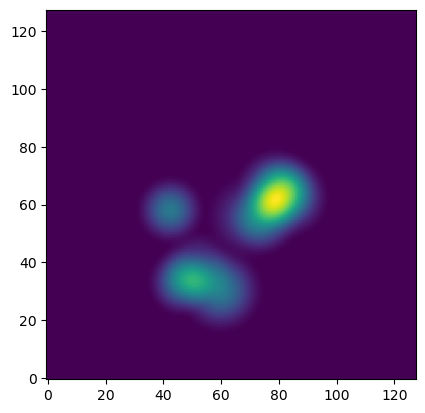

In [2]:
plt.imshow(permittivity_mat, origin='lower')

In [3]:
def single_loop(i, freq, inc_dir, out_dir):        
    mat = []
    vec = []
    
    kx = 2 * pi * freq * cos(inc_dir[i])
    ky = 2 * pi * freq * sin(inc_dir[i])

    psi = CF((exp(1j * kx * x) * exp(1j * ky * y)))

    u_scat = dg.solve(kx, ky, permittivity)

    for j_angle in out_dir:
        p_kx = 2 * pi * freq * cos(j_angle)
        p_ky = 2 * pi * freq * sin(j_angle)

        phi = CF((exp(1j * p_kx * x) * exp(1j * p_ky * y)))

        true_val = Integrate( (permittivity - background_permittivity) * (phi) *  (u_scat + psi) * (IfPos((x)**2 + (y)**2 - (1.5) **2, 0, 1)), dg.mesh)

        test_func = dg.fes.TestFunction()

        linear_form = LinearForm(dg.fes)

        linear_form += test_func * (phi) *  (psi) * (IfPos((x)**2 + (y)**2 - (1.5) **2, 0, 1)) * dx

        linear_form.Assemble()
            
        mat.append(linear_form.vec.FV().NumPy())
        vec.append(true_val)

    return mat, vec

def assemble_linear_sys(freq=0.4, n_in_dir=32, n_out_dir=8):

    A = Matrix(2 * n_in_dir * n_out_dir, dg.fes.ndof, complex=True)
    b = Vector(2 * n_in_dir * n_out_dir, complex=True)

    # incident and test directions are aligned to maximize the captured frequency domain
    inc_dir = np.linspace(0, 2 * np.pi, n_in_dir, endpoint=False)
    out_dir = np.linspace(0, 2 * np.pi, n_out_dir, endpoint=False)

    start = time.time()
    
    with multiprocessing.Pool(n_process) as p:
        tasks = [p.apply_async(single_loop, [i, freq, inc_dir, out_dir]) for i in range(n_in_dir)]

        finished = {}
        
        # postprocessing step
        while len(finished) != len(tasks):
            for i, task in enumerate(tasks):
                if task.ready():
                    finished[i] = task.get()
                    for j in range(n_out_dir):
                        index = i * n_out_dir + j
                        A.NumPy()[2 * index, :]     = finished[i][0][j].real
                        A.NumPy()[2 * index + 1, :] = finished[i][0][j].imag
                        b[2 * index]                = finished[i][1][j].real
                        b[2 * index + 1]            = finished[i][1][j].imag
                    
    end_time = time.time()

    print('freq: {}, parallel time: {}'.format(freq, end_time - start))
    
    return A.NumPy(),  b.NumPy()

In [4]:
A, b = assemble_linear_sys(freq=0.5)

freq: 0.5, parallel time: 13.932427883148193


In [5]:
start = time.time()

v = lstsq(A,  b, rcond=1e-2)[0]

end_time = time.time()

print('solving time: {}'.format(end_time - start))

permittivity_update =  GridFunction(dg.fes)
permittivity_update.vec.data = v

scene = Draw(permittivity_update, dg.mesh)
clear_output() # redraw the scene with a new height
scene.Draw(height="50vh")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

In [6]:
permittivity_update_mat = export_mat(permittivity_update, dg.mesh)

scipy.io.savemat('permittivity_update.mat', {'value':permittivity_update_mat})

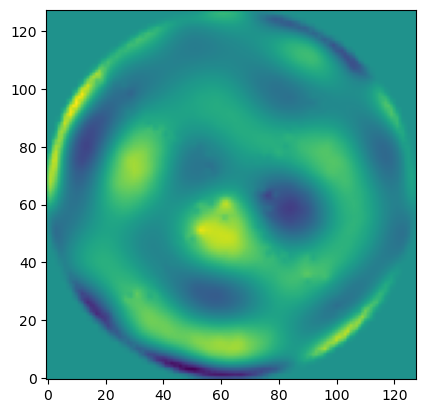

In [7]:
plt.imshow(permittivity_update_mat.real, origin='lower')